<a href="https://colab.research.google.com/github/Satwikram/Deep-Learning-Implementations/blob/master/Image%20%2B%20Text/Image%20%2B%20Text%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to kaggle

In [1]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the Dataset

In [2]:
!kaggle datasets download -d fushenggg/3-class-cat-dog-car-dataset

 98% 121M/123M [00:00<00:00, 182MB/s] 
100% 123M/123M [00:00<00:00, 147MB/s]


In [3]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

  0% 0.00/3.30M [00:00<?, ?B/s]
100% 3.30M/3.30M [00:00<00:00, 177MB/s]


In [ ]:
!unzip /content/3-class-cat-dog-car-dataset.zip
!unzip /content/news-headlines-dataset-for-sarcasm-detection.zip

### Importing Dependencies

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re

import os
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling1D, BatchNormalization, Embedding, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import spacy
from unicodedata import normalize

from tqdm import tqdm

### Loading the data

In [63]:
df = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
df.drop(columns="article_link", axis=1, inplace = True)

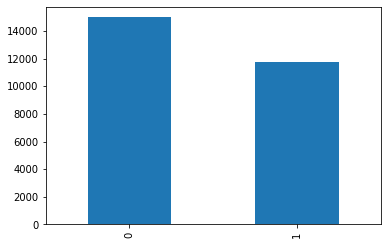

In [64]:
df["is_sarcastic"].value_counts().plot(kind="bar");

### Cleaning the Data

In [65]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [66]:
def clean_text(text):

    text = normalize("NFKD", text) #Normalization

    text = re.sub(r"[^\w\s]","", text) #Remove Punc

    text = " ".join([token.lemma_ for token in nlp(text) if not token.is_stop])

    text = re.sub("\s+", " ", text)

    return text

In [67]:
def clean_img(fname):

  target_size = (150, 150)
  img = plt.imread(fname)

  img = cv2.resize(img, target_size) 

  # Normalization
  img = img/255.0

  return img

### Taking Dataset

In [68]:
data_dir = Path(r"/content/cats_dogs_cars/cats_dogs_cars/data")

labels = {"car": 0, "cat": 1, "dog": 2}

X1 = []

y1 = []

for fname in tqdm(os.listdir(data_dir)):

  img = clean_img(data_dir / fname)

  X1.extend([img])
  y1.extend([labels[fname.split(".")[0]]])

X1 = np.array(X1)
y1 = np.array(y1)

100%|██████████| 3000/3000 [00:10<00:00, 288.89it/s]


In [69]:
df_1 = df[df['is_sarcastic']==0].sample(len(X1)//2, random_state=42, replace=False)
df_2 = df[df['is_sarcastic']==1].sample(len(X1)//2, random_state=42, replace=False)

df = pd.concat([df_1, df_2])

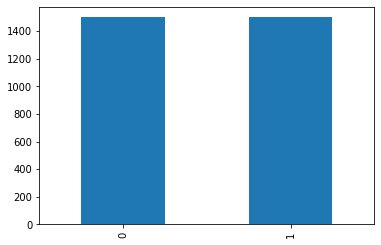

In [70]:
df["is_sarcastic"].value_counts().plot(kind="bar");

In [71]:
df["headline"] = df["headline"].apply(clean_text)

X2 = df["headline"].values
y2 = df["is_sarcastic"].values

In [72]:
X1.shape, X2.shape

((3000, 150, 150, 3), (3000,))

### Text Tokenization

In [73]:
vocab_size = 10000
embedding_dim = 16
max_length = 150

tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<oov>")

tokenizer.fit_on_texts(X2)
sequence = tokenizer.texts_to_sequences(X2)

X2 = pad_sequences(sequence, maxlen = max_length, truncating = "post")

### Spliting Data into Train and Test

In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42, stratify=y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42, stratify=y2)

### Building the model

In [75]:
def build_model():

  input1 = Input(shape=X_train1[0].shape, name="Image Input Layer")
  input2 = Input(shape=X_train2[0].shape, name="Text Input Layer")

  x1 = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation="relu")(input1)
  x1 = MaxPool2D(pool_size=(2,2))(x1)
  x1 = BatchNormalization()(x1)

  x1 = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation="relu")(x1)
  x1 = MaxPool2D(pool_size=(2,2))(x1)
  x1 = BatchNormalization()(x1)

  x1 = Flatten()(x1)
  x1 = Dense(units=512, activation="relu")(x1)

  output1 = Dense(units=3, activation="softmax", name="image_output")(x1)

  x2 = Embedding(vocab_size, embedding_dim, input_length = max_length)(input2)
  
  x2 = Bidirectional(LSTM(64, return_sequences = True))(x2)
  x2 = Bidirectional(LSTM(64))(x2)
  x2 = Dense(64, activation = "relu")(x2)
  
  output2 = Dense(1, activation="sigmoid", name="text_output")(x2)

  # Building Model
  model = Model(inputs=[input1, input2], outputs=[output1, output2])

  print(model.summary())

  tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, dpi=300, expand_nested=True,
                            show_layer_activations=True)
  
  
  return model

In [76]:
model = build_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image Input Layer (InputLayer)  [(None, 150, 150, 3  0          []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 146, 146, 25  19456       ['Image Input Layer[0][0]']      
                                6)                                                                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 73, 73, 256)  0          ['conv2d_2[0][0]']               
                                                                                            

### Compiling the model

In [77]:
model.compile(
    loss = {
        "image_output": tf.keras.losses.SparseCategoricalCrossentropy(),
        "text_output": tf.keras.losses.BinaryCrossentropy(),
    },

    metrics = {
        "image_output": 'accuracy',
        "text_output": 'accuracy',
    },

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

### Training the model

In [78]:
model.fit([X_train1, X_train2], [y_train1, y_train2])

75/75 [==============================] - 33s 161ms/step - loss: 40.1636 - image_output_loss: 39.4728 - text_output_loss: 0.6908 - image_output_accuracy: 0.5821 - text_output_accuracy: 0.5263
